In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score


# Import data

In [376]:
gdpnow = pd.read_csv('gdpnow_hf.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
# Ensure that load_df index is in the same date format
gdpnow.index = pd.to_datetime(gdpnow.index)

In [377]:
gdpnow

,GSUSFCI Index,CESIUSD Index,value_MORTGAGE30US,value_CCLACBW027SBOG,value_WTISPLC,value_EXPINF1YR,value_STLPPM,value_ECIWAG,value_M2REAL,value_UNRATE,...,PCE Goods,PCE Services,Previous change in private inventories ($Bil 2009),Publication Date of Advance Estimate,Quarter being forecasted,Residential,S&L,Services exports,Services imports,Structures
Dates,,,,,,,,,,,,,,,,,,,,,
2014-05-01,99.01,-28.7,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,5.8,3.9,70.0,30/07/2014,30/06/2014,4.6,1.4,2.5,4.0,1.8
2014-05-02,99.00,-18.9,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,5.8,3.9,58.0,30/07/2014,30/06/2014,4.6,1.3,2.5,4.0,1.8
2014-05-05,99.01,-12.6,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-06,99.02,-12.0,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,5.4,3.9,58.0,30/07/2014,30/06/2014,4.5,1.3,2.7,3.3,1.8
2014-05-07,99.00,-11.2,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-15,99.34,5.4,6.66,1033.2235,74.15,2.418633,0.940888,155.8,6710.6,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-16,99.47,-2.4,6.66,1033.2235,74.15,2.418633,0.940888,155.8,6710.6,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-17,99.51,1.4,6.66,1035.5004,74.15,2.418633,0.940888,155.8,6710.6,3.7,...,3.6,2.4,77.8,25/01/2024,31/12/2023,0.2,3.6,5.6,5.7,2.0


## Let's define X and y

In [378]:
Target = 'Final_GDP_Interp'
Drop = ['GDP Nowcast', 'Final_GDP_Interp', 'Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
       'Days until advance estimate', 'Forecast Error', 'Data releases']

# How to deal with all the NAs ?

From here on lets try two different datasets as in how to work with the NAs:
1. ffil
2. dropping NAs

In [379]:
len(gdpnow.columns)

63

In [380]:
gdpnow_filled = gdpnow.fillna(method='ffill')
# Two variables are empty quite a lot
gdpnow_dropped = gdpnow.dropna(axis=0, thresh=len(gdpnow.columns)-2)

In [381]:
gdpnow_filled.shape, gdpnow_dropped.shape

((2537, 63), (1496, 63))

# Defining X and y

We now need the X and Y for the three different data sets

In [382]:
# defining X and y for all three data sets (initial, dropped and filled)
X = gdpnow.drop(columns=Drop)
y = gdpnow[Target]

X_filled = gdpnow_filled.drop(columns=Drop)
y_filled = gdpnow_filled[Target]

X_dropped = gdpnow_dropped.drop(columns=Drop)
y_dropped = gdpnow_dropped[Target]

assert(X.shape[0]==y.shape[0])
assert(X_filled.shape[0]==y_filled.shape[0])
assert(X_dropped.shape[0]==y_dropped.shape[0])

In [383]:
X_dropped

,GSUSFCI Index,CESIUSD Index,value_MORTGAGE30US,value_CCLACBW027SBOG,value_WTISPLC,value_EXPINF1YR,value_STLPPM,value_ECIWAG,value_M2REAL,value_UNRATE,...,"Net Exports (previous, $Bil 2009)",PCE,PCE Goods,PCE Services,Previous change in private inventories ($Bil 2009),Residential,S&L,Services exports,Services imports,Structures
Dates,,,,,,,,,,,,,,,,,,,,,
2014-05-01,99.01,-28.7,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,-414.0,4.5,5.8,3.9,70.0,4.6,1.4,2.5,4.0,1.8
2014-05-02,99.00,-18.9,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,-414.0,4.6,5.8,3.9,58.0,4.6,1.3,2.5,4.0,1.8
2014-05-06,99.02,-12.0,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,-414.0,4.4,5.4,3.9,58.0,4.5,1.3,2.7,3.3,1.8
2014-05-09,99.04,-9.1,4.21,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,-414.0,4.4,5.4,3.9,72.0,4.5,1.3,2.7,3.3,1.8
2014-05-12,99.01,-6.6,4.21,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,-414.0,4.4,5.4,3.9,72.0,4.5,1.3,2.7,3.3,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-11,99.35,8.1,6.66,1033.2235,74.15,2.418633,0.940888,155.8,6710.6,3.7,...,-930.7,2.6,2.5,2.6,77.8,0.1,3.6,5.6,5.7,2.1
2024-01-12,99.34,7.5,6.66,1033.2235,74.15,2.418633,0.940888,155.8,6710.6,3.7,...,-930.7,2.6,2.5,2.6,77.8,0.1,3.6,5.6,5.7,2.0
2024-01-17,99.51,1.4,6.66,1035.5004,74.15,2.418633,0.940888,155.8,6710.6,3.7,...,-930.7,2.8,3.6,2.4,77.8,0.2,3.6,5.6,5.7,2.0


In [384]:
# Splitting into test and train sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = \
    train_test_split(X_filled, y_filled, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = \
    train_test_split(X_dropped, y_dropped, test_size=0.20)


# Pipeline

In [385]:
preproc = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

preproc_selector = Pipeline([
    ('preprocessing', preproc),  # Include the preprocessing steps with PCA
    ('feature_selection', SelectPercentile(
        mutual_info_regression,
        percentile=43 # Keep 90% of all features
    ))
])

# Modeling

In [386]:
#Modeling with initial dataset

# model = XGBRegressor(random_state=42)

# param_distributions = {
#     'model__n_estimators': [200],
#     'model__learning_rate': [0.1],
#     'model__max_depth': [16, 20],
# }

# pipe = Pipeline([
#     ('preprocessor', preproc),
#     ('model', model)
# ])

# random_search = RandomizedSearchCV(
#     pipe,
#     param_distributions=param_distributions,
#     n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
#     scoring='r2',  # Assuming MSE is the metric of interest; adjust as needed.
#     cv=5,
#     verbose=2,
#     #random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# random_search.fit(X_train, y_train)

# print("Best parameters found: ", random_search.best_params_)
# print("Best score found: ", random_search.best_score_)

In [387]:
# random_search.score(X_test, y_test)

In [388]:
# #Modeling with filled dataset

# model = XGBRegressor(random_state=42)

# param_distributions = {
#     'model__n_estimators': [200],
#     'model__learning_rate': [0.1],
#     'model__max_depth': [16, 20],
# }

# pipe = Pipeline([
#     ('preprocessor', preproc),
#     ('model', model)
# ])

# random_search_filled = RandomizedSearchCV(
#     pipe,
#     param_distributions=param_distributions,
#     n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
#     scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
#     cv=5,
#     verbose=0,
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# random_search_filled.fit(X_filled_train, y_filled_train)

# print("Best parameters found: ", random_search_filled.best_params_)
# print("Best score found: ", random_search_filled.best_score_)

In [389]:
# random_search_filled.score(X_filled_test, y_filled_test)

In [390]:
#Modeling with 'dropped' dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [200],
    'model__learning_rate': [0.1],
    'model__max_depth': [16, 20],
}

pipe = Pipeline([
    ('preprocessor', preproc),
    ('model', model)
])

random_search_dropped = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_dropped.fit(X_dropped_train, y_dropped_train)

print("Best parameters found: ", random_search_dropped.best_params_)
print("Best score found: ", random_search_dropped.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/javierasua/.pyenv/versions/3.10.6/envs/project-btm/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   2.5s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   2.6s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   2.6s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   2.7s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   2.7s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   2.8s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   2.9s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   2.9s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   1.4s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   1.4s


In [391]:
random_search_dropped.score(X_dropped_test, y_dropped_test)

-0.20929323290743043

In [392]:
y_dropped_pred = random_search_dropped.predict(X_dropped_test)

In [393]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate evaluation metrics
mae_train = mean_absolute_error(y_dropped_train, random_search_dropped.predict(X_dropped_train))
mae_test = mean_absolute_error(y_dropped_test, random_search_dropped.predict(X_dropped_test))
r2_train = r2_score(y_dropped_train, random_search_dropped.predict(X_dropped_train))
r2_test = r2_score(y_dropped_test, random_search_dropped.predict(X_dropped_test))

print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

Train MAE: 0.0005514370237678553
Test MAE: 0.20929323290743043
Train R^2: 0.999999985063569
Test R^2: 0.9873067405550342


# Finetuning

### Using a feature selector

We have shown that either filling in or dropping gives way more promising results than just imputing

Thus, we will focus on these approaches

In [394]:
#Modeling with filled dataset

# model = XGBRegressor(random_state=42)

# param_distributions = {
#     'model__n_estimators': [200],
#     'model__learning_rate': stats.uniform(0.01 , 0.5),
#     'model__max_depth': [16, 20],
#      'preprocessor_selector__feature_selection__percentile': [60, 70, 80, 90],
# }

# pipe = Pipeline([
#     ('preprocessor_selector', preproc_selector),
#     ('model', model)
# ])

# random_search_filled = RandomizedSearchCV(
#     pipe,
#     param_distributions=param_distributions,
#     n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
#     scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
#     cv=5,
#     verbose=0,
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# random_search_filled.fit(X_filled_train, y_filled_train)

# print("Best parameters found: ", random_search_filled.best_params_)
# print("Best score found: ", random_search_filled.best_score_)

In [395]:
#Modeling with dropped dataset

""" model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': stats.randint(100,300),
    'model__learning_rate': stats.uniform(0.01 , 0.5),
    'model__max_depth': stats.randint(6,20),
    'preprocessor_selector__feature_selection__percentile': stats.uniform(10,90),
}

pipe = Pipeline([
    ('preprocessor_selector', preproc_selector),
    ('model', model)
])

random_search_dropped = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=1000,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_dropped.fit(X_dropped_train, y_dropped_train)

print("Best parameters found: ", random_search_dropped.best_params_)
print("Best score found: ", random_search_dropped.best_score_) """

' model = XGBRegressor(random_state=42)\n\nparam_distributions = {\n    \'model__n_estimators\': stats.randint(100,300),\n    \'model__learning_rate\': stats.uniform(0.01 , 0.5),\n    \'model__max_depth\': stats.randint(6,20),\n    \'preprocessor_selector__feature_selection__percentile\': stats.uniform(10,90),\n}\n\npipe = Pipeline([\n    (\'preprocessor_selector\', preproc_selector),\n    (\'model\', model)\n])\n\nrandom_search_dropped = RandomizedSearchCV(\n    pipe,\n    param_distributions=param_distributions,\n    n_iter=1000,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.\n    scoring=\'neg_mean_absolute_error\',  # Assuming MSE is the metric of interest; adjust as needed.\n    cv=5,\n    verbose=0,\n    random_state=42,\n    n_jobs=-1  # Use all available cores\n)\n\nrandom_search_dropped.fit(X_dropped_train, y_dropped_train)\n\nprint("Best parameters found: ", random_search_dropped.best_params_)\nprint("Best score found: 

In [396]:
random_search_dropped.score(X_dropped_test, y_dropped_test)
# {'model__learning_rate': 0.2793508989763571, 'model__max_depth': 9, 'model__n_estimators': 105, 'preprocessor_selector__feature_selection__percentile': 43.47394011251784}

-0.20929323290743043

# Best Parameters

In [397]:
# {'model__learning_rate': 0.27629471627579294, 'model__max_depth': 12, 'model__n_estimators': 200, 'preprocessor_selector__feature_selection__percentile': 43.23074333589065}

# Fitting best model 

In [398]:
# Defining the best model

model_best =  XGBRegressor(n_estimators=200, max_depth = 9, learning_rate = 0.275, random_state=42, reg_lambda = 0.01)


# Creating the pipeline with memory caching
pipe_best = make_pipeline(preproc_selector, model_best)

# Assuming X_train and y_train are already defined and contain your training data
score = cross_val_score(pipe_best, X_dropped_train, y_dropped_train, cv=5, scoring='neg_mean_absolute_error')

# Printing the standard deviation and mean of the cross-validation scores
print(score.std())
print(score.mean())

0.035125244036565965
-0.21972543441753745


In [399]:
pipe_best.fit(X_dropped_train, y_dropped_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('imputer', KNNImputer()),
                                                  ('scaler', RobustScaler())])),
                                 ('feature_selection',
                                  SelectPercentile(percentile=43,
                                                   score_func=<function mutual_info_regression at 0x13e96c670>))])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.275,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

# Predictions

In [400]:
y_pred = pipe_best.predict(X_dropped_test)

In [401]:
y_pred = pd.Series(y_pred).reset_index(drop = True)

In [402]:
y_pred.index = y_dropped_test.index
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_plot = pd.concat([gdpnow.loc[X_dropped_test.index]['Days until advance estimate'], y_dropped_test, y_pred], axis=1)


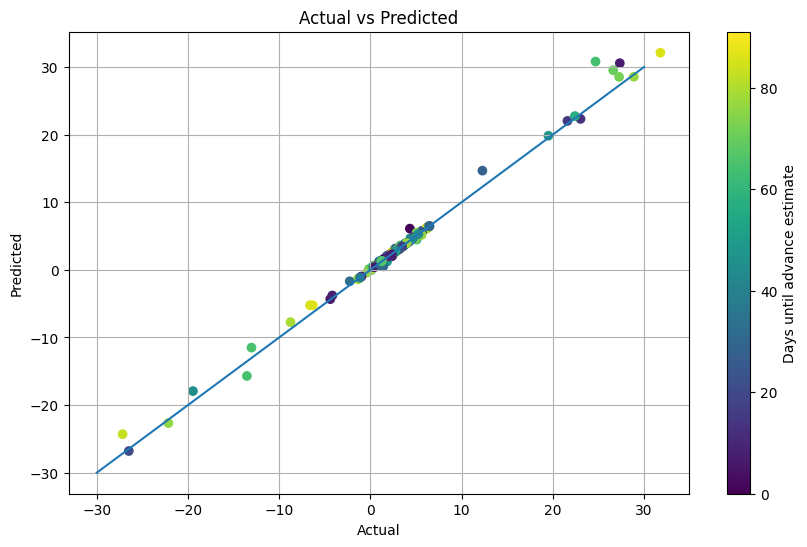

In [403]:
a=[-30,30]
b=[-30,30]

plt.figure(figsize=(10, 6))
plt.plot(a,b)
scatter = plt.scatter(df_plot['Final_GDP_Interp'], df_plot[0], c=df_plot['Days until advance estimate'], cmap='viridis')
plt.colorbar(scatter, label='Days until advance estimate')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Comparing scores with GDPNOW

In [404]:
gdpnow_test = gdpnow_dropped['GDP Nowcast']
gdpnow_test = gdpnow_test.interpolate(method='time')
gdp_test = gdpnow_dropped['Final_GDP_Interp']

In [405]:
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    if type(y_pred) == pd.Series:
        mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
        maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    else:
        mins = np.amin(np.hstack([y_pred.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
        maxs = np.amax(np.hstack([y_pred.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

In [406]:
forecast_accuracy(pipe_best.predict(X_dropped_test), y_dropped_test)

{'mape': 0.059007678611124346,
 'me': 0.08241972908587819,
 'mae': 0.17410275760901578,
 'mpe': -0.0020052337989655625,
 'rmse': 0.5631936812128875,
 'acf1': -0.06581471402745072,
 'corr': 0.9957251211137358,
 'minmax': 0.04362404200930736}

In [407]:
forecast_accuracy(gdpnow_test,gdp_test)

/var/folders/fd/kbx0rzp563731_k5gv52hvmr0000gn/T/ipykernel_20042/1438552970.py:15: RuntimeWarning: divide by zero encountered in divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


{'mape': 1.0052173257056338,
 'me': 0.4431112847125225,
 'mae': 2.7196656763835896,
 'mpe': 0.22596797133268812,
 'rmse': 7.243805910567935,
 'acf1': 0.9706041856039092,
 'corr': 0.5693452275251626,
 'minmax': inf}

# Loss curves

[0]	validation_0-mae:1.96248	validation_1-mae:1.82574
[1]	validation_0-mae:1.44861	validation_1-mae:1.33965
[2]	validation_0-mae:1.08775	validation_1-mae:1.00927
[3]	validation_0-mae:0.81519	validation_1-mae:0.75499
[4]	validation_0-mae:0.61346	validation_1-mae:0.57356
[5]	validation_0-mae:0.46819	validation_1-mae:0.45657
[6]	validation_0-mae:0.36436	validation_1-mae:0.37847
[7]	validation_0-mae:0.28171	validation_1-mae:0.32295
[8]	validation_0-mae:0.22065	validation_1-mae:0.27892
[9]	validation_0-mae:0.17914	validation_1-mae:0.25514
[10]	validation_0-mae:0.14774	validation_1-mae:0.23740
[11]	validation_0-mae:0.12563	validation_1-mae:0.22688
[12]	validation_0-mae:0.10667	validation_1-mae:0.21735
[13]	validation_0-mae:0.08987	validation_1-mae:0.20555
[14]	validation_0-mae:0.07894	validation_1-mae:0.20056
[15]	validation_0-mae:0.07154	validation_1-mae:0.19796
[16]	validation_0-mae:0.06668	validation_1-mae:0.19652
[17]	validation_0-mae:0.05883	validation_1-mae:0.19140
[18]	validation_0-ma

/Users/javierasua/.pyenv/versions/3.10.6/envs/project-btm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-mae:0.02979	validation_1-mae:0.17617
[34]	validation_0-mae:0.02949	validation_1-mae:0.17613
[35]	validation_0-mae:0.02889	validation_1-mae:0.17564
[36]	validation_0-mae:0.02849	validation_1-mae:0.17551
[37]	validation_0-mae:0.02822	validation_1-mae:0.17532
[38]	validation_0-mae:0.02795	validation_1-mae:0.17547
[39]	validation_0-mae:0.02775	validation_1-mae:0.17539
[40]	validation_0-mae:0.02724	validation_1-mae:0.17533
[41]	validation_0-mae:0.02685	validation_1-mae:0.17501
[42]	validation_0-mae:0.02649	validation_1-mae:0.17499
[43]	validation_0-mae:0.02603	validation_1-mae:0.17476
[44]	validation_0-mae:0.02581	validation_1-mae:0.17475
[45]	validation_0-mae:0.02561	validation_1-mae:0.17476
[46]	validation_0-mae:0.02546	validation_1-mae:0.17466
[47]	validation_0-mae:0.02527	validation_1-mae:0.17479
[48]	validation_0-mae:0.02514	validation_1-mae:0.17476
[49]	validation_0-mae:0.02460	validation_1-mae:0.17469
[50]	validation_0-mae:0.02450	validation_1-mae:0.17462
[51]	valid

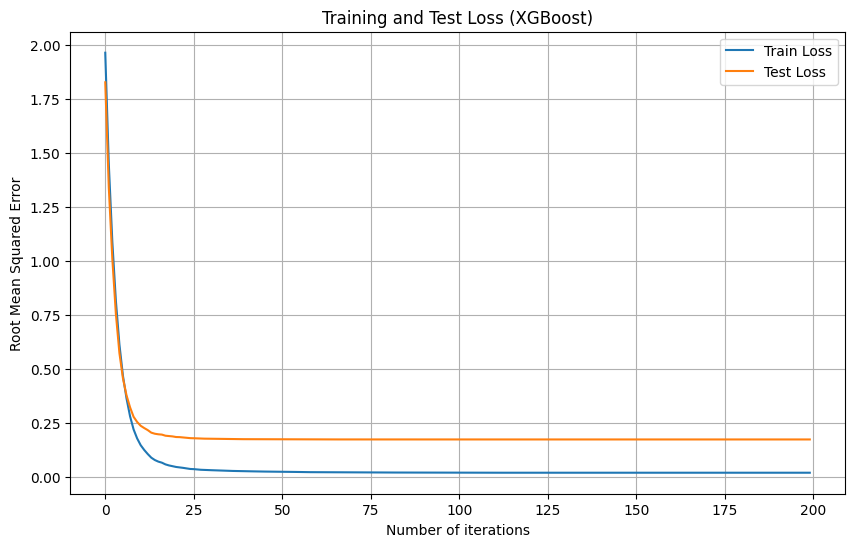

In [408]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you have your X_train, y_train, X_test, and y_test data prepared

# Define the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(n_estimators=200, max_depth = 9, learning_rate = 0.275, random_state=42, reg_lambda = 0.01)

X_train_preproc = preproc_selector.fit_transform(X_dropped_train, y_dropped_train)
X_test_preproc = preproc_selector.transform(X_dropped_test)

# Fit the model with evaluation set
eval_set = [(X_train_preproc, y_dropped_train), (X_test_preproc, y_dropped_test)]
xgb_regressor.fit(X_train_preproc, y_dropped_train, eval_set=eval_set, eval_metric="mae", verbose=True)

# Extract training and validation loss from the model's history
results = xgb_regressor.evals_result()
train_loss = results['validation_0']['mae']
test_loss = results['validation_1']['mae']

# Plot the train and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Number of iterations')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Test Loss (XGBoost)')
plt.legend()
plt.grid()
plt.show()

# Using test_data.csv 

In [409]:
test_data = pd.read_csv('data/test_data.csv', index_col='Release Date', parse_dates=True) #date_parser=dateparse)
# Ensure that load_df index is in the same date format
test_data.index = pd.to_datetime(test_data.index)
test_data = test_data.dropna()


/var/folders/fd/kbx0rzp563731_k5gv52hvmr0000gn/T/ipykernel_20042/4022950943.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  test_data = pd.read_csv('data/test_data.csv', index_col='Release Date', parse_dates=True) #date_parser=dateparse)


### Check if release data is same as interpolated data in gdpnow

In [410]:
cutoff_date_1 = gdpnow.index[0]
cutoff_date_2 = gdpnow.index[-1]

rows_to_remove_1 = test_data.index[test_data.index < cutoff_date_1]
rows_to_remove_2 = test_data.index[test_data.index > cutoff_date_2]
# Drop the rows using the index positions
test_data = test_data.drop(rows_to_remove_1)
test_data = test_data.drop(rows_to_remove_2)

from pandas.testing import assert_series_equal
assert_series_equal(test_data["BEA's Advance Estimate"], gdpnow.loc[test_data.index]['Final_GDP_Interp'], check_names=False)

### New train and test


In [411]:
X_test = pd.DataFrame()

for date in test_data.index:
    if date in X_dropped.index:
        X_test = X_test.append(X_dropped.loc[date])
    else:
        prev_date = date - pd.DateOffset(days=1)
        while prev_date not in X_dropped.index and prev_date >= min(X_dropped.index):
            prev_date -= pd.DateOffset(days=1)
        if prev_date in X_dropped.index:
            X_test = X_test.append(X_dropped.loc[prev_date])


/var/folders/fd/kbx0rzp563731_k5gv52hvmr0000gn/T/ipykernel_20042/3718472905.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(X_dropped.loc[prev_date])
/var/folders/fd/kbx0rzp563731_k5gv52hvmr0000gn/T/ipykernel_20042/3718472905.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(X_dropped.loc[prev_date])
/var/folders/fd/kbx0rzp563731_k5gv52hvmr0000gn/T/ipykernel_20042/3718472905.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(X_dropped.loc[prev_date])
/var/folders/fd/kbx0rzp563731_k5gv52hvmr0000gn/T/ipykernel_20042/3718472905.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [412]:
y_test = test_data['BEA\'s Advance Estimate']
y_test.index = X_test.index
gdnow_testdata = test_data['Model Forecast Right Before BEA\'s Advance Estimate']
gdnow_testdata.index = X_test.index
X_train = X_dropped.drop(X_test.index)
y_train = y_dropped.drop(X_test.index)

# Refitting best model on new Train and Test

pipe_best.fit(X_train, X_test)

In [413]:
pipe_best.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('imputer', KNNImputer()),
                                                  ('scaler', RobustScaler())])),
                                 ('feature_selection',
                                  SelectPercentile(percentile=43,
                                                   score_func=<function mutual_info_regression at 0x13e96c670>))])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.275,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [414]:
forecast_accuracy(pipe_best.predict(X_test), y_test)

{'mape': 0.07134096887222098,
 'me': 0.0383822098217513,
 'mae': 0.20739835096032985,
 'mpe': 0.027883095361110766,
 'rmse': 0.4380547570407669,
 'acf1': -0.5704109425753526,
 'corr': 0.998838933010879,
 'minmax': 0.04466276695508575}

In [416]:
predictions = pipe_best.predict(X_test)
btm_error = predictions - y_test
gdpnow_error = gdnow_testdata-y_test


df = pd.DataFrame({
    'BTM Predictions': predictions,
    'BEA\'s Advance Estimate': y_test,
    'GDP Now' : gdnow_testdata,
    'BTM Error' : btm_error,
    'GDP Now Error' : gdpnow_error


})

df


,BTM Predictions,BEA's Advance Estimate,GDP Now,BTM Error,GDP Now Error
2023-10-25,4.719473,4.88,5.41,-0.160527,0.53
2023-07-26,2.348911,2.41,2.41,-0.061089,0.00
2023-04-26,1.103087,1.06,1.13,0.043087,0.07
2023-01-20,2.864167,2.89,3.53,-0.025833,0.64
2022-10-26,2.339232,2.57,3.09,-0.230768,0.52
2022-07-27,-0.943645,-0.93,-1.20,-0.013645,-0.27
2022-04-27,-1.228765,-1.41,0.37,0.181235,1.78
2022-01-26,6.634096,6.89,6.50,-0.255904,-0.39
2021-10-27,2.354941,2.02,0.19,0.334941,-1.83
2021-07-28,6.494530,6.50,6.43,-0.005470,-0.07
